# STRAT - Short Tandem Repeat Analysis Tool

## 2. Collect statistics on high fidelity reads - IMPROVED

### 2.1 Imports

In [1]:
from csv import QUOTE_NONE
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pandas as pd
import seaborn as sns

### 2.2 Arguments

In [2]:
motif = 'CAG'

# pcr2persons guppy
# threshold = 100
# input_path = '/opt/data/pcr2persons/output/guppy/guppy.ontarget.tsv'
# output_path = '/opt/data/pcr2persons/output/guppy/'

# pcr2persons dorado
# threshold = 100
# input_path = '/opt/data/pcr2persons/output/dorado/dorado.ontarget.tsv'
# output_path = '/opt/data/pcr2persons/output/dorado/'

# jovan guppy
# threshold = 100
# input_path = '/opt/data/jovan/output/guppy/guppy.ontarget.tsv'
# output_path = '/opt/data/jovan/output/guppy/'

# jovan dorado
# threshold = 100
# input_path = '/opt/data/jovan/output/dorado/dorado.ontarget.tsv'
# output_path = '/opt/data/jovan/output/dorado/'

# dm108 guppy
threshold = 10
input_path = '/opt/data/dm108/output/guppy/guppy.ontarget.tsv'
output_path = '/opt/data/dm108/output/guppy/'

### 2.3 Constants

In [3]:
def rev_comp(seq, comps):
    return ''.join(comps.get(n, n) for n in reversed(seq))


DIRECTIONS = ['fwd', 'rev']

COMPLEMENT = {
    'A': 'T',
    'C': 'G',
    'G': 'C',
    'T': 'A'
}

MOTIFS = {
    'fwd': motif,
    'rev': rev_comp(motif, COMPLEMENT)
}

COLUMNS = [
    'direction',
    'id',
    'prefix_flank',
    'ins',
    'suffix_flank',
    'prefix_flank_q',
    'ins_q',
    'suffix_flank_q',
]

COLUMNS_SEQ = [
    'prefix_flank',
    'ins',
    'suffix_flank',
]

COLUMNS_LEN = ['len_' + s for s in COLUMNS_SEQ]

COLUMNS_SEQ_IMP = ['ins_imp']
COLUMNS_LEN_IMP = ['len_ins_imp']

### 2.4 Functions

In [4]:
def lengths(df, columns_seq, columns_len):
    for s, l in zip(columns_seq, columns_len):
        df[l] = df[s].str.len()
        df[l + '_adj'] = (df[l] / 3).round().astype(int)
    return df


def load(input_path, columns, columns_seq, columns_len):
    df = pd.read_csv(input_path, sep='\t', header=None, dtype=str, quoting=QUOTE_NONE)
    df.columns = columns

    return df


def get_abundant_lengths(df, column_seq, column_len, threshold):
    dfg = df.groupby(column_len)[column_seq].count().reset_index()

    cond = dfg[column_seq] > threshold
    dfg = dfg[cond]
    return dfg


def consensus_string(strings):
    if not strings or not all(len(strings[0]) == len(s) for s in strings):
        raise ValueError("Input strings must be non-empty and of equal length")

    consensus = ''
    for i in range(len(strings[0])):
        # Create a dictionary to count occurrences of each character at the current position
        char_count = {}
        for s in strings:
            char = s[i]
            char_count[char] = char_count.get(char, 0) + 1

        # Find the most frequent character at the current position
        most_frequent_char = max(char_count, key=char_count.get)

        # Append the most frequent character to the consensus string
        consensus += most_frequent_char

    return consensus


def get_consensus_strings(df, abundant_lengths, column_len, column_seq, directions):
    consensi = []
    for l in sorted(abundant_lengths):
        for direction in directions:
            cond = df[column_len] == l
            cond &= df['direction'] == direction
            strings = list(df[cond][column_seq])
            if strings:
                consensi.append([direction, l, len(strings), consensus_string(strings)])
    
    df_consensus = pd.DataFrame(consensi, columns=['direction', 'len_ins', 'count', 'seq'])
    return df_consensus

### 2.5 Main

#### 2.5.1 Load the data

In [5]:
df = load(input_path, COLUMNS, COLUMNS_SEQ, COLUMNS_LEN)

In [6]:
print(df.columns)
df.head(3)

Index(['direction', 'id', 'prefix_flank', 'ins', 'suffix_flank',
       'prefix_flank_q', 'ins_q', 'suffix_flank_q'],
      dtype='object')


,direction,id,prefix_flank,ins,suffix_flank,prefix_flank_q,ins_q,suffix_flank_q
0,rev,@4b634639-0c99-4e34-aa2f-ee69f3dd8f45,GCCGGGAATG,CTGCTGCTGC,TGCTGGGGGG,0132545433,58=><=<<>=,>?@?><<?A9
1,rev,@e2c68d98-4964-4c5b-8031-377f5b46c8f5,GCCGGGAATG,CTGCTGCTA,TTCTGGGGGG,"',-0446544",479::9:;2,10///68>>8
2,fwd,@cce360fc-acc0-433b-ab4e-1e897175f709,GTGATCCCCC,AGCAGCAGCAGC,AGCATTCCCG,8<<;;;<>><,:>34>=444*)),&&%&+++/41


In [7]:
def improve_ins(row):
    prefix = row['prefix_flank']
    ins = row['ins']
    suffix = row['suffix_flank']
    motif = MOTIFS[row['direction']]
    target = 2 * motif
    window = len(target)
    for s in range(window - 1):
        # i in (window-1)..1
        i = window - 1 - s
        if prefix[-i:] + ins[:window - i] == target:
            ins = prefix[-i:] + ins
            break
    
    for s in range(window - 1):
        # i in 1..(window-1)
        i = s + 1
        if ins[-i:] + suffix[:window - i] == target:
            ins = ins + suffix[:window - i]
            break

    return ins

df['ins_imp'] = df.apply(improve_ins, axis=1)

In [8]:
df = lengths(df, COLUMNS_SEQ+COLUMNS_SEQ_IMP, COLUMNS_LEN+COLUMNS_LEN_IMP)

In [9]:
df['direction'].value_counts()

direction
fwd    57331
rev    49244
Name: count, dtype: int64

In [10]:
for direction in DIRECTIONS:
    cond = df['direction'] == direction
    for c in COLUMNS_LEN:
        vc = df[cond][c].value_counts()
        print(f"{direction} - {c}: {vc.index[0]} ({vc.iloc[0]})")

fwd - len_prefix_flank: 10 (57331)
fwd - len_ins: 10 (9724)
fwd - len_suffix_flank: 10 (57331)
rev - len_prefix_flank: 10 (49244)
rev - len_ins: 10 (28372)
rev - len_suffix_flank: 10 (49244)


#### 2.5.2 Old-school

In [11]:
dfg = get_abundant_lengths(df, 'ins_imp', 'len_ins_imp', threshold)
abundant_lengths = set(dfg['len_ins_imp'])

cond = df['len_ins'].isin(abundant_lengths)
df = df[cond]

In [12]:
dfc = get_consensus_strings(df, abundant_lengths, 'len_ins_imp', 'ins_imp', DIRECTIONS)

dfc.to_csv(f'{output_path}consensus.ontarget.imp.tsv', index=False, sep='\t')

dfc.head(3)

,direction,len_ins,count,seq
0,fwd,6,6,CGGCCG
1,rev,6,13,CTGCTG
2,fwd,7,21,CAGCAGC


/tmp/ipykernel_24523/597721656.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  gfg.set_xticklabels(gfg.get_xticklabels(), rotation=90)


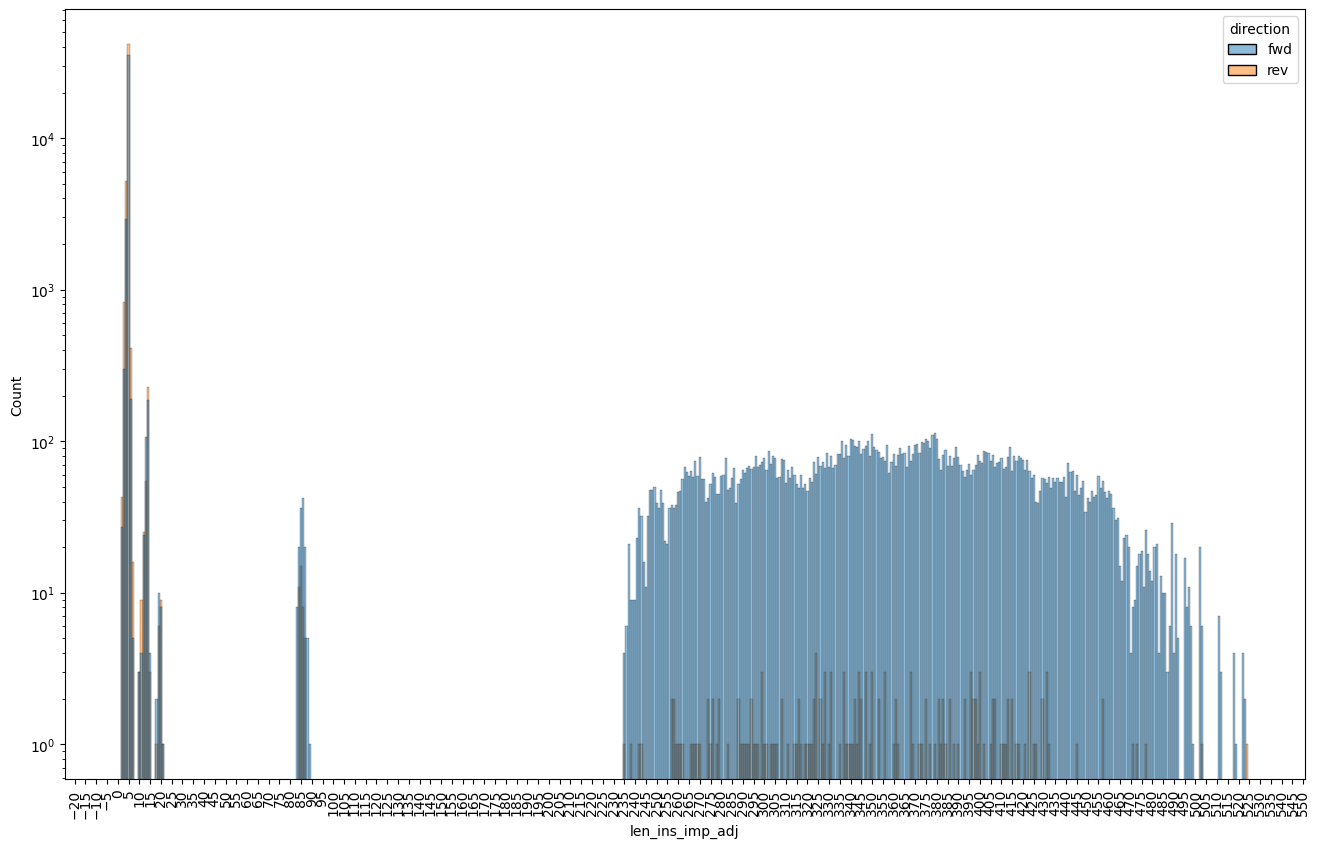

In [13]:
fig, ax = plt.subplots(figsize=(16, 10))
gfg = sns.histplot(df.sort_values('direction'), x='len_ins_imp_adj', discrete=True, hue='direction')
# gfg.set_xlim(0, 1000)
gfg.set_yscale("log")
loc = plticker.MultipleLocator(base=5)
gfg.xaxis.set_major_locator(loc)
gfg.set_xticklabels(gfg.get_xticklabels(), rotation=90)
fig.savefig(f'{output_path}inserts.ontarget.imp.png')

In [14]:
# fig, ax = plt.subplots(figsize=(16, 10))
# gfg = sns.histplot(df, x='len_prefix_flank', discrete=True, hue='direction')
# gfg.set_xlim(0, 500)
# gfg.set_yscale("log")